<a href="https://colab.research.google.com/github/BagiyaLakshmi/image-shadow-removal-challenge/blob/main/Imagemanipulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./datasets

In [ ]:
!unzip -qo '/content/drive/MyDrive/datasets/train-data-shadow-affected.zip' -d "/content/datasets/train_data_shadow" & unzip -qo "/content/drive/MyDrive/datasets/train-data-shadow-free.zip" -d "/content/datasets/train_data_free" & unzip -qo "/content/drive/MyDrive/datasets/validate.zip" -d "/content/datasets/validate"

In [ ]:
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.misc
from skimage.metrics import structural_similarity as ssim


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

In [ ]:
img_shadow = cv2.imread(r'/content/datasets/train_data_shadow/0010.png')
img_free = cv2.imread(r'/content/datasets/train_data_free/0010.png')

In [ ]:
img_shadow = cv2.cvtColor(img_shadow,cv2.COLOR_BGR2RGB)
img_free = cv2.cvtColor(img_free,cv2.COLOR_BGR2RGB)

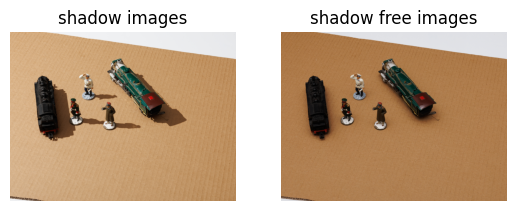

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img_shadow)
plt.axis('off')
plt.title('shadow images')
plt.subplot(1,2,2)
plt.imshow(img_free)
plt.axis('off')
plt.title('shadow free images')
plt.show()

In [ ]:
print(img_shadow.shape)
print(img_shadow.itemsize)
print(img_shadow.strides)

(1440, 1920, 3)
1
(5760, 3, 1)


In [ ]:
print(img_shadow.nbytes)
print(img_shadow.size)

8294400
8294400


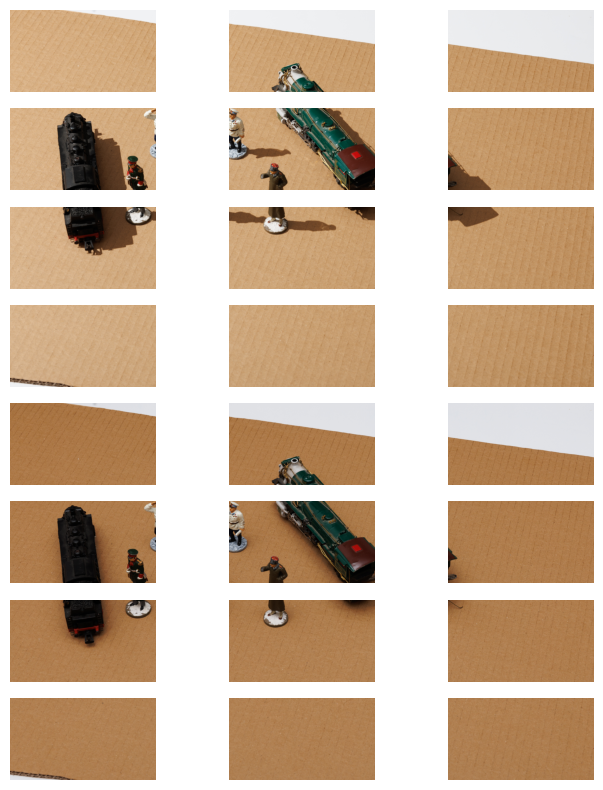

In [ ]:
# inefficient lazy implementation

plt.figure(figsize=(8,10))
sub_count=1
for i in range(4):
  for j in range(3):
    plt.subplot(8,3,sub_count)
    sub_count+=1
    plt.imshow(img_shadow[i*360:(i+1)*360,j*640:(j+1)*640,:])
    plt.axis('off')

sub_count=13
for i in range(4):
  for j in range(3):
    plt.subplot(8,3,sub_count)
    sub_count+=1
    plt.imshow(img_free[i*360:(i+1)*360,j*640:(j+1)*640,:])
    plt.axis('off')

plt.show()

In [ ]:
def reshape_split(image:np.ndarray,sub_image_size:tuple):
  img_height,img_width,channels = image.shape
  tile_height,tile_width = sub_image_size
  assert(img_height%tile_height==0 and img_width%tile_width==0)

  bytelength = image.nbytes // image.size
  tiled_array = image.reshape(img_height // tile_height, tile_height, img_width // tile_width, tile_width, channels)
  tiled_array = tiled_array.swapaxes(1,2)
  tiled_array = tiled_array.reshape(-1,tile_height,tile_width, channels)

  return tiled_array



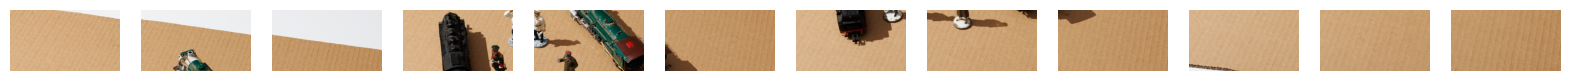

In [ ]:
plt.figure(figsize=(20,5))
for index,i in enumerate(reshape_split(img_shadow,(360,640))):
  plt.subplot(1,12,index+1)
  plt.imshow(i)
  plt.axis('off')

plt.show()

In [ ]:
# tensor manipulation
img_ten = transforms.functional.to_tensor(Image.open(r'/content/datasets/train_data_shadow/0010.png'))
print(img_ten.shape)
print(img_ten.stride())
print(img_ten[:,50:60,50:55])

torch.Size([3, 1440, 1920])
(2764800, 1920, 1)
tensor([[[0.8275, 0.8353, 0.8275, 0.8314, 0.8275],
         [0.8157, 0.8275, 0.8314, 0.8392, 0.8353],
         [0.8118, 0.8353, 0.8471, 0.8471, 0.8392],
         [0.8196, 0.8314, 0.8431, 0.8392, 0.8392],
         [0.8196, 0.8196, 0.8275, 0.8392, 0.8392],
         [0.8314, 0.8235, 0.8353, 0.8510, 0.8471],
         [0.8392, 0.8353, 0.8353, 0.8392, 0.8353],
         [0.8196, 0.8196, 0.8235, 0.8235, 0.8314],
         [0.8314, 0.8314, 0.8392, 0.8235, 0.8275],
         [0.8392, 0.8392, 0.8353, 0.8196, 0.8275]],

        [[0.6549, 0.6667, 0.6667, 0.6667, 0.6627],
         [0.6431, 0.6627, 0.6706, 0.6784, 0.6745],
         [0.6471, 0.6706, 0.6863, 0.6941, 0.6863],
         [0.6549, 0.6627, 0.6784, 0.6824, 0.6784],
         [0.6667, 0.6627, 0.6667, 0.6784, 0.6784],
         [0.6824, 0.6745, 0.6784, 0.6902, 0.6784],
         [0.6745, 0.6784, 0.6784, 0.6784, 0.6667],
         [0.6588, 0.6588, 0.6588, 0.6588, 0.6627],
         [0.6706, 0.6706, 0.6706,

In [ ]:
# img_ten = img_ten.reshape(4,360,3,640,3)
# img_ten.swapaxes(1,2)
# print(img_ten.shape)
# print(img_ten.stride())

torch.Size([4, 360, 3, 640, 3])
(2073600, 5760, 1920, 3, 1)


In [ ]:
# img_height,img_width,channels = img_ten.shape
# print(img_height,img_width,channels)

In [ ]:
def reshape_ten(image:torch.tensor,sub_image_size:tuple):
  channels , img_height,img_width, = image.shape
  tile_height,tile_width = sub_image_size
  assert(img_height%tile_height==0 and img_width%tile_width==0)
  image = torch.moveaxis(image,(0,1,2),(2,0,1))
  image = image.reshape(img_height // tile_height, tile_height, img_width // tile_width, tile_width, channels)
  image = image.swapaxes(1,2)
  image = image.reshape(-1,tile_height,tile_width,channels)
  image = image.moveaxis((3,1,2),(1,2,3))
  return image


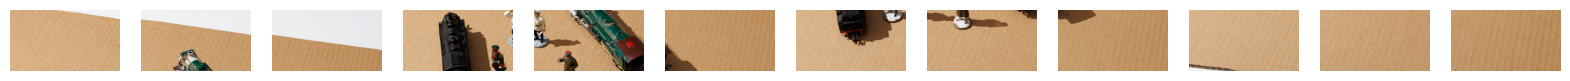

In [ ]:
plt.figure(figsize=(20,5))
tensor_images = (reshape_ten(img_ten,(360,640)))
tensor_images = np.moveaxis(tensor_images.numpy(),(1,2,3),(3,1,2))
for index,i in enumerate(tensor_images):
  plt.subplot(1,12,index+1)
  plt.imshow(i)
  plt.axis('off')

plt.show()

In [ ]:
def reshape_img(ten:torch.tensor,img_size:tuple):
  n_tiles,n_channels,tile_height,tile_width = ten.shape
  img_h,img_w = img_size
  assert(img_h%tile_height==0 and img_w%tile_width==0)
  ten = ten.moveaxis((1,2,3),(3,1,2))
  ten = ten.reshape(img_h//tile_height,img_w//tile_width,tile_height,tile_width,n_channels)
  ten = ten.swapaxes(2,1)
  ten = ten.reshape(img_h,img_w,n_channels)

  return ten


In [ ]:
TILE_SIZE = (360,640)
IMG_SIZE = (1440,1920)
ten = reshape_ten(img_ten,TILE_SIZE)
print(ten.shape)
img_arr = reshape_img(ten,IMG_SIZE).numpy()
print(img_arr.shape)

torch.Size([12, 3, 360, 640])
(1440, 1920, 3)


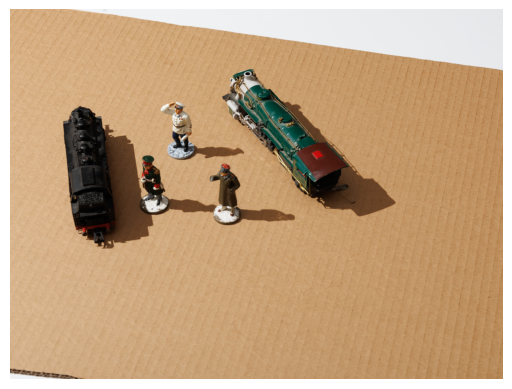

In [ ]:
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/datasets/image_files.csv')
data.sample(n=5)

,x,y
997,/content/datasets/train_data_shadow/0622.png,/content/datasets/train_data_free/0622.png
818,/content/datasets/train_data_shadow/0979.png,/content/datasets/train_data_free/0979.png
157,/content/datasets/train_data_shadow/0227.png,/content/datasets/train_data_free/0227.png
924,/content/datasets/train_data_shadow/0065.png,/content/datasets/train_data_free/0065.png
899,/content/datasets/train_data_shadow/0174.png,/content/datasets/train_data_free/0174.png


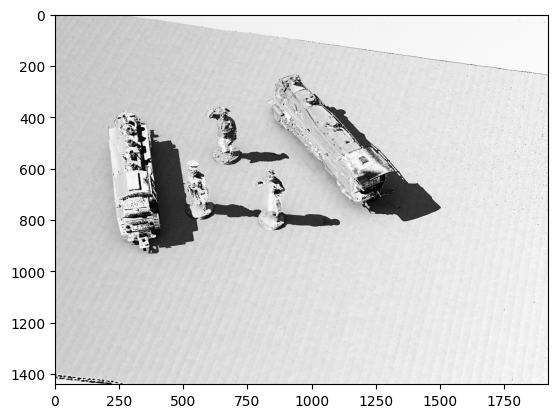

In [ ]:
plt.imshow(cv2.cvtColor(img_free - img_shadow,cv2.COLOR_RGB2GRAY),cmap='gray')

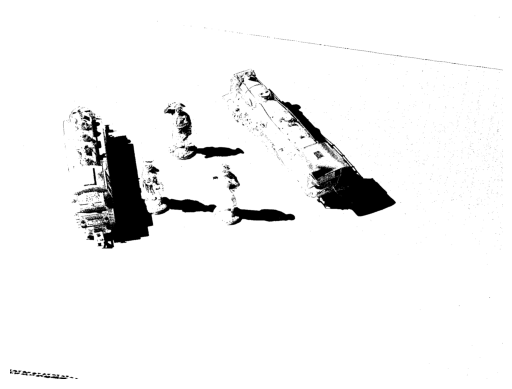

In [ ]:
img_bin = cv2.cvtColor(img_free - img_shadow,cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(img_bin,127,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print(thresh1[600:650,530:550])

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255   0]
 [255 255 255 255 255 255 255 255 255 255 255   0   0 255 255   0   0 255
  255   0]
 [255   0 255 255 255 255 255 255 255 255 255   0   0 255 255   0 255 255
  255 255]
 [  0 255 255   0   0 255 255 255 255 255 255 255   0 255 255 255 255 255
  255   0]
 [  0 255   0   0   0 255 255 255 255 255 255 255   0   0 255 255 255 255
  255   0]
 [255 255 255 255 255 255 255 255 255 255 255 255   0   0 255 255

In [ ]:
img1_bg = np.empty((1440,1920,3),dtype=np.uint8)

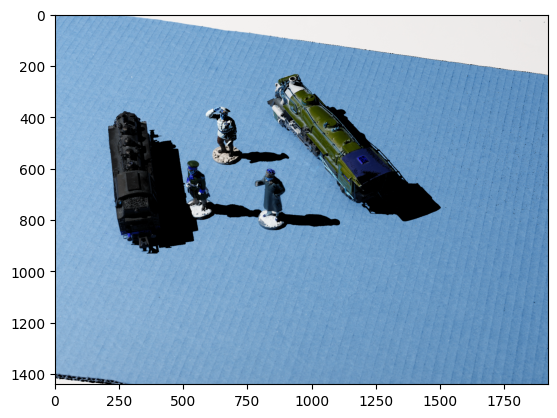

In [ ]:
img1_bg[:,:,0] = cv2.bitwise_and(img_shadow[:,:,0],thresh1)
img1_bg[:,:,1] = cv2.bitwise_and(img_shadow[:,:,1],thresh1)
img1_bg[:,:,2] = cv2.bitwise_and(img_shadow[:,:,2],thresh1)
plt.imshow(img1_bg)

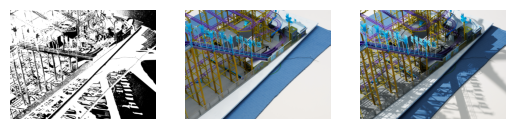

In [ ]:
img_bin = cv2.cvtColor(cv2.imread(r'/content/datasets/train_data_free/0050.png') - cv2.imread(r'/content/datasets/train_data_shadow/0050.png'),cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(img_bin,40,255,cv2.THRESH_BINARY)
plt.subplot(1,3,1)
plt.imshow(thresh1,cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.imread(r'/content/datasets/train_data_free/0050.png'))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.imread(r'/content/datasets/train_data_shadow/0050.png'))
plt.axis('off')
plt.show()

In [ ]:
# a shadow mask model have to be trained, preferably a UNET
# https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7